# Import Required Libraries
This section imports the necessary libraries for data processing and model building.

In [4]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

/Users/mymac/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 1) Read CSV Data
Load the training data from the CSV file and display basic information.

In [6]:
train_df = pd.read_csv("archive/train.csv")

# The 'id' column contains image file names, e.g., "00000.jpg"
# The 'has_cactus' column contains 0 or 1 (label)

print("Number of training data:", len(train_df))
print(train_df)

Number of training data: 17500
                                         id  has_cactus
0      0004be2cfeaba1c0361d39e2b000257b.jpg           1
1      000c8a36845c0208e833c79c1bffedd1.jpg           1
2      000d1e9a533f62e55c289303b072733d.jpg           1
3      0011485b40695e9138e92d0b3fb55128.jpg           1
4      0014d7a11e90b62848904c1418fc8cf2.jpg           1
...                                     ...         ...
17495  ffede47a74e47a5930f81c0b6896479e.jpg           0
17496  ffef6382a50d23251d4bc05519c91037.jpg           1
17497  fff059ecc91b30be5745e8b81111dc7b.jpg           1
17498  fff43acb3b7a23edcc4ae937be2b7522.jpg           0
17499  fffd9e9b990eba07c836745d8aef1a3a.jpg           1

[17500 rows x 2 columns]


# 2) Prepare Train & Validation Split
Split the dataset into training and validation sets for model evaluation.

In [7]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df["has_cactus"]
)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Train size: 14000, Validation size: 3500


# 3) Image Data Generator
Use `ImageDataGenerator` for data augmentation and loading images from directories.

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # normalization [0..1]
    horizontal_flip=True,   # horizontal flip augmentation
    vertical_flip=False,    # can try True
    rotation_range=15,      # rotation
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen = ImageDataGenerator(rescale=1./255)

# path to train images folder
train_dir = "archive/train/train/"
# path to test images folder
test_dir = "archive/test/test/"

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='id',
    y_col='has_cactus',
    target_size=(32, 32),   # image size
    batch_size=32,
    class_mode='raw',       # since our labels are 0/1, choose 'raw'
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='id',
    y_col='has_cactus',
    target_size=(32, 32),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

Found 14000 validated image filenames.
Found 3500 validated image filenames.


# 4) Build a Simple CNN Model
Define and compile a Convolutional Neural Network (CNN) model.

In [9]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # output 0/1
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,977 (652.25 KB)

 Trainable params: 166,977 (652.25 KB)

 Non-trainable params: 0 (0.00 B)

# 5) Training
Train the model for a specified number of epochs.

In [10]:
EPOCHS = 50

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

Epoch 1/50


/Users/mymac/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8456 - loss: 0.3452 - val_accuracy: 0.9197 - val_loss: 0.2117
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9250 - loss: 0.2019 - val_accuracy: 0.9443 - val_loss: 0.1703
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9352 - loss: 0.1770 - val_accuracy: 0.9606 - val_loss: 0.1113
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9429 - loss: 0.1488 - val_accuracy: 0.9311 - val_loss: 0.1795
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9479 - loss: 0.1403 - val_accuracy: 0.9640 - val_loss: 0.1063
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9598 - loss: 0.1119 - val_accuracy: 0.9297 - val_loss: 0.1980
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9641 - loss: 0.1078 - val_accuracy: 0.9671 - val_loss: 0.1022
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9628 - loss: 0.1071 - val_accuracy: 0.946

# 6) Evaluation / Visualization of Results (Optional)
Visualize the training and validation accuracy and loss.

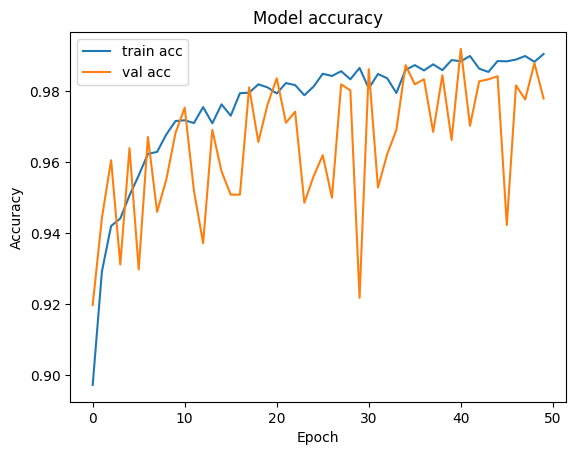

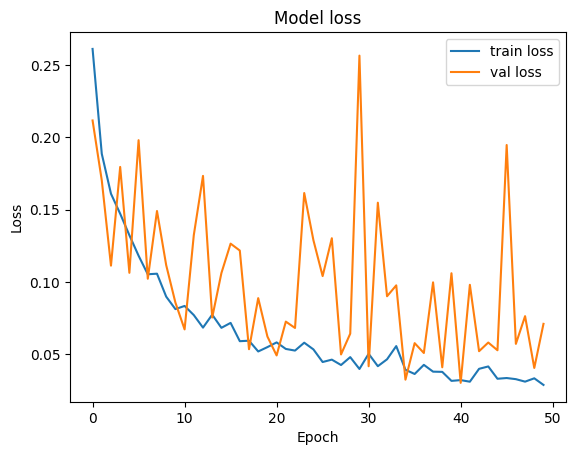

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 7) Predict Test Data
Generate predictions for the test dataset.

In [12]:
test_filenames = sorted(os.listdir(test_dir))
# if there are files other than jpg images, filter them here

test_df = pd.DataFrame({"id": test_filenames})

test_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id',
    y_col=None,  # no labels
    target_size=(32, 32),
    batch_size=32,
    class_mode=None,
    shuffle=False  # do not shuffle
)

preds = model.predict(test_generator)
# Since we use sigmoid in the output, preds values are in the range [0..1]
# We can use a threshold of 0.5
pred_labels = (preds > 0.5).astype(int).reshape(-1)

# Check the first 10 predictions
print("Example predictions on test data:")
for i in range(10):
    print(test_df.iloc[i]['id'], "->", pred_labels[i])

Found 4000 validated image filenames.
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Example predictions on test data:
000940378805c44108d287872b2f04ce.jpg -> 1
0017242f54ececa4512b4d7937d1e21e.jpg -> 1
001ee6d8564003107853118ab87df407.jpg -> 0
002e175c3c1e060769475f52182583d0.jpg -> 0
0036e44a7e8f7218e9bc7bf8137e4943.jpg -> 1
0038ed6f7417b8275b393307f66cb1e3.jpg -> 1
0059dfa41de4441fc23b9a4b98ba99cb.jpg -> 1
0061bd302d735db829418cb90b4e6040.jpg -> 1
00754573d8c7223e73da553dd43780bd.jpg -> 1
008d9fce71c8e03a4c9cdd15ea908573.jpg -> 0


# 8) Save Predictions (Optional)
Save the predictions to a CSV file for submission.

In [13]:
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "has_cactus": pred_labels
})
submission_df.to_csv("my_submission.csv", index=False)
print("\nFile 'my_submission.csv' has been saved successfully.")


File 'my_submission.csv' has been saved successfully.


In [16]:
#show the first 10 rows of the submission file
print("\nFirst 10 rows of the submission file:")
submission_df.head(10)


First 10 rows of the submission file:


,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1
1,0017242f54ececa4512b4d7937d1e21e.jpg,1
2,001ee6d8564003107853118ab87df407.jpg,0
3,002e175c3c1e060769475f52182583d0.jpg,0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1
5,0038ed6f7417b8275b393307f66cb1e3.jpg,1
6,0059dfa41de4441fc23b9a4b98ba99cb.jpg,1
7,0061bd302d735db829418cb90b4e6040.jpg,1
8,00754573d8c7223e73da553dd43780bd.jpg,1
9,008d9fce71c8e03a4c9cdd15ea908573.jpg,0
